In [1]:
import sys
sys.path.insert(0, '../stellargraph')

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

# Загрузка данных

Скачиваем и распаковываем данные с http://snap.stanford.edu/pathways/

Загружаем полностью граф. Этот мы слегка покалечим, чтобы все считалось быстро:

In [3]:
df = pd.read_csv("LP_NC_materials/bio_pathways_network.csv")

Загружаем полностью граф. Этот мы использовать не будем, просто хочется сравнить наш урезанный граф с исходным:

In [4]:
df2 = pd.read_csv("LP_NC_materials/bio_pathways_network.csv")

In [5]:
G2 = nx.from_pandas_edgelist(df2, "Gene ID 1", "Gene ID 2", create_using=nx.Graph())

Информация о списке связей:

In [6]:
df.shape

(342353, 2)

In [7]:
df.columns

Index(['Gene ID 1', 'Gene ID 2'], dtype='object')

In [8]:
df = df.iloc[np.random.choice(np.arange(df.shape[0]), 1000)]

Создаем networkx граф из списка связей:

In [9]:
G = nx.from_pandas_edgelist(df, "Gene ID 1", "Gene ID 2", create_using=nx.Graph())

In [10]:
print(nx.info(G))

Graph with 1642 nodes and 998 edges


/var/folders/yb/wggwjwh14qbdcq2x0m710g4ssgjxzk/T/ipykernel_38732/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [11]:
print(nx.info(G2))

Graph with 21557 nodes and 342353 edges


/var/folders/yb/wggwjwh14qbdcq2x0m710g4ssgjxzk/T/ipykernel_38732/265060720.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G2))


Как видно, мы очень сильно покалечили граф, поэтому вряд ли модели, которые мы получим быстро, будут хорошо работать. Упражнение на дом: сосчитать все для непокалеченного графа.

Нарисуем визуализацию:

In [12]:
pos = nx.circular_layout(G)

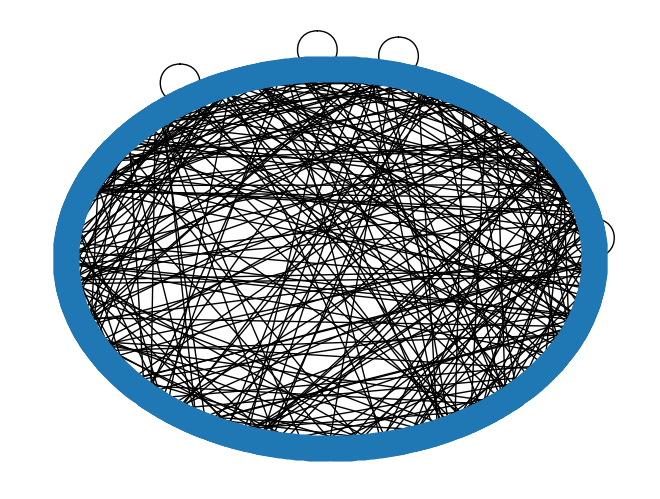

In [13]:
nx.draw(G, with_labels=False, pos=pos)

# Разметка данных для node classification

Тут нам нужно найти для каждого узла из графа болезнь, что его затрагивает. Для простоты мы считаем, что один ген может отвечать только за одну болезнь, но одна болезнь может соответствовать многим генам. Вообще говоря, это не так, но для текущего упражнения достаточно.

Собираем данные об аттрибутах:

In [14]:
attr_df = pd.read_csv("LP_NC_materials/bio_pathways_associations.csv")

In [15]:
attr_df.shape

(519, 3)

In [16]:
attr_df

,Disease ID,Disease Name,Associated Gene IDs
0,C0036095,Salivary Gland Neoplasms,"1462, 1612, 182, 2011, 2019, 2175, 2195, 23209..."
1,C0033941,"Psychoses, Substance-Induced","135, 1636, 207, 2099, 2912, 2950, 3350, 3362, ..."
2,C0043459,Zellweger Syndrome,"3295, 5189, 5190, 5192, 5193, 5194, 5195, 5567..."
3,C0033860,Psoriasis,"100271719, 10318, 10498, 10547, 10758, 10866, ..."
4,C0027726,Nephrotic Syndrome,"1277, 1282, 1284, 2, 213, 2152, 2247, 2262, 29..."
...,...,...,...
514,C0005684,Malignant neoplasm of urinary bladder,"10460, 1198, 2261, 342184, 3845, 4046, 54575, ..."
515,C0752347,Lewy Body Disease,"177, 1906, 199, 2629, 2670, 348, 3480, 3481, 3..."
516,C3160718,"PARKINSON DISEASE, LATE-ONSET","126, 1621, 170534, 1815, 23317, 26281, 2629, 2..."
517,C0311375,Arsenic Poisoning,"10142, 10308, 10443, 1401, 2067, 2071, 2072, 2..."


Создаем список узлов:

In [17]:
nodes = np.array(list(G.nodes))

Для каждого узла:    
   * для каждой болезни:    
       * если список затронутых генов включает в себя узел, то добавить эту болезнь в словарь "узел"-"болезнь" и перейти к следующему узлу

In [18]:
diseases = {}
for a in tqdm(nodes):
    for b in np.arange(attr_df.shape[0]):
        current = attr_df.iloc[b]
        if str(a) in current["Associated Gene IDs"].split(", "):
            diseases[a] = current["Disease Name"]
            break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1642/1642 [00:10<00:00, 163.15it/s]


In [19]:
diseases

{3190: 'Mammary Neoplasms',
 202559: 'melanoma',
 23619: 'Salivary Gland Neoplasms',
 80270: 'Cholestasis',
 1432: 'Myocardial Ischemia',
 1557: 'Kidney Failure, Chronic',
 6716: 'Alopecia',
 5338: 'Cardiomegaly',
 6733: 'Schizophrenia',
 5562: 'Impaired glucose tolerance',
 975: 'Common Variable Immunodeficiency',
 23435: 'Amyotrophic Lateral Sclerosis',
 3921: 'Neoplasm Invasiveness',
 81569: 'Peripheral Neuropathy',
 5080: 'Autistic Disorder',
 6663: 'Kallmann Syndrome',
 3981: 'Multiple Myeloma',
 5478: 'Peripheral Neuropathy',
 6628: 'Disease Progression',
 127343: 'Seizure Adverse Event',
 1314: 'Lung Diseases, Interstitial',
 3482: 'Liver carcinoma',
 8554: 'Dermatologic disorders',
 10987: 'Liver carcinoma',
 6223: 'Prostatic Neoplasms',
 3725: 'Juvenile arthritis',
 4171: 'Colonic Neoplasms',
 7803: 'IGA Glomerulonephritis',
 7157: 'Psoriasis',
 7283: 'Microcephaly',
 9217: 'Amyotrophic Lateral Sclerosis',
 6185: 'Prostatic Neoplasms',
 5133: 'Multiple Sclerosis',
 8544: 'Cont

# Разметка данных для link prediction

Здесь мы добиваемся следующего:
1. нужно собрать тренировочный и тестовый наборы;    
2. в них должны быть истинно позитивные и истинно негативные ссылки.
    * Истинно позитивные - те, что заведомо присутствуют в исходном графе, истинно позитивные в тестовой выборке мы удалим из графа, чтобы получить хорошую тренировочную выборку;
    * Истинно негативные - те, что заведомо отсутствуют в исходном графе. Их мы наберем из матрицы смежности.

In [20]:
from sklearn.model_selection import train_test_split

Создаем матрицу смежности:

In [21]:
adj_G = nx.to_numpy_matrix(G, nodelist=nodes)

In [22]:
adj_G.shape

(1642, 1642)

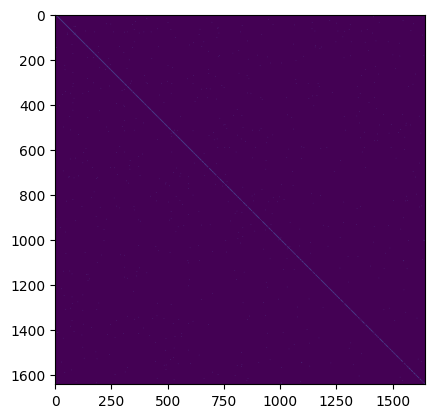

In [23]:
plt.imshow(adj_G)

Для каждого столбца в матрице смежности:    
* для каждой строки в матрице смежности:    
   * если связи между столбцом и строкой нет, то добавить соответствующую пару в словарь
   * остановиться, если количество больше либо равно 100

In [24]:
unconnected = {"G1": [], "G2": []}
for i in tqdm(np.arange(adj_G.shape[0])):
    for j in np.arange(i, adj_G.shape[0]):
        if i != j:
            if adj_G[i,j] == 0:
                unconnected["G1"].append(nodes[i])
                unconnected["G2"].append(nodes[j])
                if len(unconnected["G1"]) >= 100:
                    break
unconnected = pd.DataFrame(unconnected)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1642/1642 [00:00<00:00, 312295.25it/s]


In [25]:
unconnected.shape

(1739, 2)

Истинно негативные - случайная выборка из несвязанных:

In [26]:
true_zero = unconnected.iloc[np.random.choice(np.arange(unconnected.shape[0]), len(unconnected), replace=False)]

In [27]:
true_zero_train_ix, true_zero_test_ix = train_test_split(np.arange(true_zero.shape[0]), test_size=100)

Истинно позитивные - случайная выборка из списка связей:

In [28]:
true_one_train_ix, true_one_test_ix = train_test_split(np.arange(df.shape[0]), test_size=100)

Создаём граф без истинно позитивных, попавших в тестовую выборку:

In [29]:
G_no_one = nx.from_pandas_edgelist(df.iloc[true_one_train_ix], "Gene ID 1", "Gene ID 2", create_using=nx.Graph())

# Эмбеддинги на графах

Конвертируем граф в формат StellarGraph:

In [30]:
G_no_one_st = StellarGraph.from_networkx(G_no_one)

Пробегаемся случайным блужданием по графу. Упражнение на дом: попробовать другие параметры случайного блуждания.

In [31]:
rw = BiasedRandomWalk(G_no_one_st)

In [32]:
walks = rw.run(nodes=list(G_no_one_st.nodes()), length=20, n=5, p=0.4)

In [113]:
for w in walks[:15]:
    print(w)

[9972, 5594, 9972, 5594, 9972, 5594, 5590, 433, 5590, 433, 5590, 433, 5590, 433, 5590, 433, 5590, 433, 5590, 433]
[9972, 5594, 708, 5594, 9972, 5594, 5590, 5594, 5590, 5594, 5590, 5594, 708, 5594, 9972, 5594, 9972, 5594, 5590, 5594]
[9972, 5594, 5590, 5594, 708, 5594, 708, 5594, 708, 5594, 708, 5594, 708, 5594, 9972, 5594, 9972, 5594, 9972, 5594]
[9972, 5594, 708, 5594, 708, 5594, 708, 5594, 708, 5594, 708, 5594, 708, 5594, 5590, 433, 5590, 433, 5590, 5594]
[9972, 5594, 9972, 5594, 5590, 5594, 5590, 433, 5590, 433, 5590, 433, 5590, 5594, 5590, 5594, 5590, 5594, 5590, 5594]
[5594, 5590, 5594, 5590, 5594, 5590, 5594, 5590, 5594, 9972, 5594, 708, 5594, 708, 5594, 708, 5594, 9972, 5594, 708]
[5594, 708, 5594, 708, 5594, 9972, 5594, 9972, 5594, 9972, 5594, 708, 5594, 9972, 5594, 708, 5594, 708, 5594, 708]
[5594, 5590, 5594, 5590, 5594, 5590, 5594, 9972, 5594, 708, 5594, 708, 5594, 9972, 5594, 5590, 433, 5590, 5594, 5590]
[5594, 708, 5594, 5590, 433, 5590, 5594, 9972, 5594, 9972, 5594, 9972,

In [33]:
print(len(walks))

7500


Конвертируем список узлов в список строк:

In [34]:
str_walks = [[str(a) for a in b] for b in walks]

In [115]:
for sw in str_walks[:10]:
    print(sw)

['9972', '5594', '9972', '5594', '9972', '5594', '5590', '433', '5590', '433', '5590', '433', '5590', '433', '5590', '433', '5590', '433', '5590', '433']
['9972', '5594', '708', '5594', '9972', '5594', '5590', '5594', '5590', '5594', '5590', '5594', '708', '5594', '9972', '5594', '9972', '5594', '5590', '5594']
['9972', '5594', '5590', '5594', '708', '5594', '708', '5594', '708', '5594', '708', '5594', '708', '5594', '9972', '5594', '9972', '5594', '9972', '5594']
['9972', '5594', '708', '5594', '708', '5594', '708', '5594', '708', '5594', '708', '5594', '708', '5594', '5590', '433', '5590', '433', '5590', '5594']
['9972', '5594', '9972', '5594', '5590', '5594', '5590', '433', '5590', '433', '5590', '433', '5590', '5594', '5590', '5594', '5590', '5594', '5590', '5594']
['5594', '5590', '5594', '5590', '5594', '5590', '5594', '5590', '5594', '9972', '5594', '708', '5594', '708', '5594', '708', '5594', '9972', '5594', '708']
['5594', '708', '5594', '708', '5594', '9972', '5594', '9972', 

Обучаем Word2Vec:

In [35]:
from gensim.models import Word2Vec

In [36]:
model = Word2Vec(str_walks, vector_size=50, workers=3)

Вот так выглядят наши эмбеддинги:

In [37]:
model.wv[str(nodes[0])]

array([ 1.0110323 ,  1.6260644 , -0.26330337, -0.01906039,  1.0374894 ,
       -1.2239933 ,  0.94778377, -0.08815369,  0.22893806,  0.6108398 ,
        1.5916438 , -0.05419799, -0.4471224 , -0.8228312 , -0.937074  ,
        0.56449205,  0.0566678 , -0.17701815, -1.0149393 ,  0.1871563 ,
        1.2631088 , -0.14631286,  1.1894138 ,  0.75268453, -0.8861647 ,
        0.00337237,  0.40555707, -1.3544788 , -0.10359063,  1.8659488 ,
        0.18237962,  0.47541535, -1.8793703 , -0.4866894 ,  0.20954838,
       -0.27283126, -0.05002486, -0.500231  ,  1.4511156 , -1.3889718 ,
        0.5823946 , -2.358863  ,  0.97866815, -0.33712742, -0.502404  ,
       -0.3568619 ,  0.44982836, -0.25345   ,  0.17765589,  1.5530604 ],
      dtype=float32)

In [116]:
print(model.wv)

KeyedVectors<vector_size=50, 1500 keys>


# Link prediction

Обучим следующую модель:    
* Основа - логистическая регрессия;   
* Входные данные - вектор из 100 элементов:
    * 1-50 -- эмбеддинг первого узла;
    * 51-100 -- эмбеддинг второго узла;
* Выходные данные - есть ссылка (1) и нет ссылки (0);
* Оцениваем обычными метриками для бинарной классификации.

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
no_one_nodes = list(G_no_one_st.nodes())

In [40]:
filter_b_0 = [
    (true_zero.iloc[a]["G1"] in no_one_nodes) and (true_zero.iloc[a]["G2"] in no_one_nodes) 
    for a in np.arange(true_zero.shape[0])
]

In [41]:
true_zero = true_zero[filter_b_0]

Сначала разбираемся с истинно негативным набором ссылок:   
* собираем векторы для первого гена
* собираем векторы для второго гена
* объединяем их, чтобы получить матрицу размерности (N, 100)

In [42]:
G1_0 = np.stack([model.wv[str(true_zero.iloc[a]["G1"])] for a in np.arange(true_zero.shape[0])])

In [43]:
G2_0 = np.stack([model.wv[str(true_zero.iloc[a]["G2"])] for a in np.arange(true_zero.shape[0])])

In [44]:
G1_0.shape

(1460, 50)

In [45]:
G1G2_0 = np.concatenate([G1_0, G2_0], 1)

In [46]:
G1G2_0.shape

(1460, 100)

In [47]:
df.columns

Index(['Gene ID 1', 'Gene ID 2'], dtype='object')

Теперь разбираемся с истинно позитивным набором ссылок:   
* фильтруем те узлы, которые точно присутствуют в графе без истинно позитивного тестового набора;
* собираем векторы для первого гена
* собираем векторы для второго гена
* объединяем их, чтобы получить матрицу размерности (N, 100)

In [48]:
filter_b_1 = [
    (df.iloc[a]["Gene ID 1"] in no_one_nodes) and (df.iloc[a]["Gene ID 2"] in no_one_nodes) 
    for a in np.arange(df.shape[0])
]

In [49]:
df_1 = df[filter_b_1]

In [50]:
G1_1 = np.stack([model.wv[str(df_1.iloc[a]["Gene ID 1"])] for a in np.arange(df_1.shape[0])])

In [51]:
G2_1 = np.stack([model.wv[str(df_1.iloc[a]["Gene ID 2"])] for a in np.arange(df_1.shape[0])])

In [52]:
G1G2_1 = np.concatenate([G1_1, G2_1], 1)

In [53]:
G1G2_1.shape

(909, 100)

In [54]:
G1G2 = np.concatenate([G1G2_1, G1G2_0], 0)

In [107]:
labels = np.array([1] * len(G1G2_1) + [0] * len(G1G2_0))

In [59]:
train_ix, test_ix = train_test_split(np.arange(G1G2.shape[0]), stratify=labels)

Обучаем логистическую регрессию:

In [60]:
lr = LogisticRegression()

In [61]:
lr.fit(G1G2[train_ix], labels[train_ix])

LogisticRegression()

In [62]:
y_hat_p = lr.predict_proba(G1G2[test_ix])

In [63]:
y_hat = lr.predict(G1G2[test_ix])

Считаем метрики:

In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef

In [65]:
accuracy_score(y_pred=y_hat, y_true=labels[test_ix])

0.5716694772344013

In [66]:
roc_auc_score(y_score=y_hat, y_true=labels[test_ix])

0.5071857726508051

In [67]:
matthews_corrcoef(y_pred=y_hat, y_true=labels[test_ix])

0.016898772226211507

In [68]:
f1_score(y_pred=y_hat, y_true=labels[test_ix])

0.2905027932960894

# Node classification

Обучим следующую модель:    
* Основа - логистическая регрессия;   
* Входные данные - вектор из 50 элементов:
    * 1-50 -- эмбеддинг узла;
* Выходные данные - относится к выбранной болезни (1) и не относится (0);
* Оцениваем обычными метриками для бинарной классификации.

Сначала выберем болезни для тех узлов, которые присутствуют в графе:

In [69]:
node_classes = np.array(["NA" if a not in diseases else diseases[a] for a in no_one_nodes])

In [70]:
classifiable_nodes = np.array(no_one_nodes)[node_classes != "NA"]

In [71]:
classifiable_nodes.shape

(662,)

In [72]:
node_classes = node_classes[node_classes != "NA"]

Узнаем, к какой болезни относится наибольшее количество узлов и будем ее использовать в качестве целевой болезни для предсказания:

In [73]:
n, c = np.unique(node_classes, return_counts=True)

In [74]:
n[c == np.max(c)]

array(['Prostatic Neoplasms'], dtype='<U51')

Размечаем датасет как 1 - относится к "Prostatic Neoplasms" и 0 - нет:

In [75]:
node_Y = np.array([int(a) for a in node_classes == 'Prostatic Neoplasms'])

In [76]:
N = np.stack([model.wv[str(a)] for a in classifiable_nodes])

In [77]:
N.shape

(662, 50)

Обучаем логистическую регрессию:

In [78]:
train_ix, test_ix = train_test_split(np.arange(N.shape[0]), stratify=node_Y)

In [79]:
lr2 = LogisticRegression()

In [80]:
lr2.fit(N[train_ix], node_Y[train_ix])

LogisticRegression()

In [81]:
node_Yhat = lr2.predict(N[test_ix])

Вычисляем метрики:

In [82]:
accuracy_score(y_pred=node_Yhat, y_true=node_Y[test_ix])

0.963855421686747

In [83]:
roc_auc_score(y_score=node_Yhat, y_true=node_Y[test_ix])

0.5

Упражнение на дом: попробовать другие модели.